In [22]:
def data_preprocess(data, train_percent, predict_col):
    np.random.seed(7)
    data = data.reindex(np.random.permutation(data.index))
    training = data.iloc[:round(data.shape[0]* train_percent),1:]
    testing = data.iloc[round(data.shape[0]* train_percent):,1:]
    training_y = training.pop(predict_col)
    testing_y = testing.pop(predict_col)
    training_x = normalization(training, training)
    testing_x = normalization(testing, training)
    return training_x, training_y, testing_x, testing_y

def normalization(x, train):
    train_mean = train.iloc[:,:].mean()
    train_std = train.iloc[:,:].std()
    normalize_x = x.copy()
    for col in range(x.shape[1]):
        normalize_x.iloc[:,col] =(x.iloc[:,col] -train_mean[col]) /train_std[col]
    return normalize_x

def RMSE(predict_y, testing_y):
    # print(np.sqrt(np.sum((predict_y - testing_y)**2) / predict_y.size))
    return np.sqrt(np.sum((predict_y - testing_y)**2) / predict_y.size)

def linear(training_x, training_y, testing_x, testing_y):
    training_xpinverse = np.linalg.pinv(training_x)
    weight_linear = np.dot(training_xpinverse, training_y)
    predict_y = np.dot(testing_x, weight_linear)
    # print(weight_linear)
    return predict_y, RMSE(predict_y,testing_y)

def linear_regulization(training_x, training_y, testing_x, testing_y, lamda, bias):
    if (bias):
        training_x['bias'] = 1
        testing_x['bias'] = 1
    identiy_size = training_x.shape[1]
    weight_regularized = np.dot(np.dot(np.linalg.inv(np.dot(training_x.T, training_x) + (lamda/2)*np.identity(identiy_size)),training_x.T),training_y)
    predict_y_regularized =  np.dot(testing_x,weight_regularized)
    return predict_y_regularized, RMSE(predict_y_regularized,testing_y)

def linear_bayesian(training_x, training_y, testing_x, testing_y, alpha, prior_mean):
    training_x['bias'] = 1
    testing_x['bias'] = 1
    identiy_size = training_x.shape[1]
    cov_matrix = (1/alpha)*np.identity(identiy_size)
    posterior_mean = np.dot(np.dot(np.linalg.inv(np.dot(training_x.T,training_x) + cov_matrix),training_x.T),training_y)
    weight_bayesian = posterior_mean
    predict_y_bayesian = np.dot(testing_x,weight_bayesian)
    return weight_bayesian, predict_y_bayesian, RMSE(predict_y_bayesian, testing_y)



In [23]:
import pandas as pd
import numpy as np
df = pd.read_csv('train.csv')
data = pd.get_dummies(df)
training_x, training_y, testing_x, testing_y = data_preprocess(data, 0.8, 'G3')

In [24]:
#b linear
predict_y,RMSE_linear = linear(training_x, training_y, testing_x, testing_y)
#c linear regulization
predict_y_reg,RMSE_reg = linear_regulization(training_x.copy(), training_y, testing_x.copy(), testing_y, lamda=1, bias=False)
#d  linear regulization with bias
predict_y_reg_bias,RMSE_reg_bias = linear_regulization(training_x.copy(), training_y, testing_x.copy(), testing_y, lamda=1, bias=True)
#e bayesian
weight_bayesian,predict_y_bayesian,RMSE_bayesian = linear_bayesian(training_x.copy(), training_y, testing_x.copy(), testing_y, alpha=1, prior_mean=0)
print("RMSE from linear: ",RMSE_linear)
print("RMSE from linear regulization: ",RMSE_reg)
print("RMSE from linear regulization with bias: ",RMSE_reg_bias)
print("RMSE from linear bayesian with bias: ",RMSE_bayesian )

RMSE from linear:  11.341623468423922
RMSE from linear regulization:  11.341570734942113
RMSE from linear regulization with bias:  1.6839557739866113
RMSE from linear bayesian with bias:  1.6834058950921422


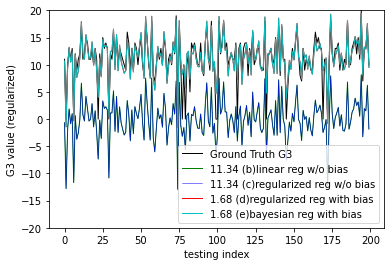

In [25]:
import matplotlib.pyplot as plt
sample_index = [x for x in range(predict_y.size)]
plt.xlabel('testing index')
plt.ylabel('G3 value (regularized)')
plt.ylim(-20, 20)
linewidth = 1
plt.plot(sample_index,testing_y,'k',label='Ground Truth G3',linewidth=linewidth)
plt.plot(sample_index,predict_y,'g',label='%.2f (b)linear reg w/o bias' %RMSE_linear,linewidth=linewidth)
plt.plot(sample_index,predict_y_reg,'b',label='%.2f (c)regularized reg w/o bias' %RMSE_reg,linewidth=0.5)
plt.plot(sample_index,predict_y_reg_bias,'r',label='%.2f (d)regularized reg with bias' %RMSE_reg_bias,linewidth=linewidth)
plt.plot(sample_index,predict_y_bayesian,'c',label='%.2f (e)bayesian reg with bias' %RMSE_bayesian,linewidth=linewidth)
plt.legend()
plt.savefig('plot.png')

In [26]:
# f
df2 = pd.read_csv('test_no_G3.csv')
data2 = pd.get_dummies(df2)

data_new = data[data2.columns]
data_new.insert(data.columns.get_loc('G2')+1, 'G3', data['G3'])
training_x_new, training_y_new, testing_x_new, testing_y_new = data_preprocess(data_new, 1,'G3') # no ID

weight_bayesian_new,_,_ = linear_bayesian(training_x_new, training_y_new, testing_x_new, testing_y_new, alpha=1, prior_mean=0)

data_new.pop('G3')
data_new.pop('ID')
data_new['bias']= 1
output_ID = data2.pop('ID')
data2['bias'] = 1

testing_x_f = normalization(data2, data_new)
testing_x_f['bias']=1
predict_y_bayesian_f = np.dot(testing_x_f,weight_bayesian_new)

print("Write R08922125 1.txt")
output = pd.DataFrame(columns=['ID', 'predict G3'])
output['ID'] = output_ID
output['predict G3'] = predict_y_bayesian_f.T
file = open("R08922125 1.txt" , "w")
np.savetxt(file, output,fmt='%d %f')
file.close()
# output.to_csv('StudentID 1.txt', sep='\t', index=False)

Write R08922125 1.txt


In [27]:
# PART 2 census income data 
print("PART 2 .....")
df3 = pd.read_csv('adult.data')
df3.to_csv('census.csv',  index = None)
data3 = pd.read_csv('census.csv',names=['age', 'workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','class'])
data3 = pd.get_dummies(data3)
data3.pop(data3.columns[-2])
data3.insert(0,'none', 0)
data3.pop('native-country_ Holand-Netherlands')
training_x_census, training_y_census, testing_x_census, testing_y_census = data_preprocess(data3, 0.8,data3.columns[-1])



PART 2 .....


In [28]:
#b linear
predict_y_census,RMSE_linear_census= linear(training_x_census, training_y_census, testing_x_census, testing_y_census)
#c linear regulization
predict_y_reg_census,RMSE_reg_census = linear_regulization(training_x_census.copy(), training_y_census, testing_x_census.copy(), testing_y_census, lamda=1, bias=False)

#d  linear regulization with bias
predict_y_reg_bias_census,RMSE_reg_bias_census = linear_regulization(training_x_census.copy(), training_y_census, testing_x_census.copy(), testing_y_census, lamda=1, bias=True)
#e bayesian
weight_bayesian_census,predict_y_bayesian_census,RMSE_bayesian_census = linear_bayesian(training_x_census.copy(), training_y_census, testing_x_census.copy(), testing_y_census, alpha=1, prior_mean=0)

print("RMSE from linear: ",RMSE_linear_census)
print("RMSE from linear regulization: ",RMSE_reg_census)
print("RMSE from linear regulization with bias: ",RMSE_reg_bias_census)
print("RMSE from linear bayesian with bias: ",RMSE_bayesian_census )

RMSE from linear:  0.41413553221803867
RMSE from linear regulization:  0.4141372195793796
RMSE from linear regulization with bias:  0.34079382567361216
RMSE from linear bayesian with bias:  0.34079357109965014


In [29]:
threshold = 0.5
predict_y_census = np.where(predict_y_census<threshold, 0, 1)
predict_y_reg_census = np.where(predict_y_reg_census<threshold, 0, 1)
predict_y_reg_bias_census = np.where(predict_y_reg_bias_census<threshold, 0, 1)  
predict_y_bayesian_census = np.where(predict_y_bayesian_census<threshold, 0, 1)

def error(predict_y, testing_y):
    return(np.sum((predict_y - testing_y)**2) / testing_y.size)

print("error rate from linear: ", error(predict_y_census,testing_y_census))
print("error rate from linear regulization: ", error(predict_y_reg_census,testing_y_census))
print("error rate from linear regulization with bias: ", error(predict_y_reg_bias_census,testing_y_census))
print("error rate from linear: ", error(predict_y_bayesian_census,testing_y_census))


error rate from linear:  0.21053439803439802
error rate from linear regulization:  0.21007371007371006
error rate from linear regulization with bias:  0.1613943488943489
error rate from linear:  0.1613943488943489
